# Summary:

#### In this spreadsheet, we setup an example of a 'clean' time series and fit an LSTM model to it. The 'clean' time series is given in the form of a sine wave. The amount of data points per period is kept fixed throughout the analysis. The error metrics scaling with the model hyper-parameters is evaluated, providing guidance on the choice of an optimal parameter setting.


#### In particular, the following questions will be analyzed:
#### - How does...?



## ToDo:
#### choose continuous function as target first. then add noise to it and magnify it. 
#### also test: add noise ontop of sine or as another feature next to it - should give same answer?
#### also check: keras.layers.RNN

# Table of contents
* [1. update](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 update](#Part1.1_link)
* [2. update](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 update](#Part2.1_link)
* [3. update](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 update](#Part3.1_link)
* [4. update](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 update](#Part4.1_link)
* [5. update](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 update](#Part5.1_link)
* [6. update](#Part6_link)
<br >&nbsp;&nbsp;&nbsp;[6.1 update](#Part6.1_link)

<a id='Part1_link'></a>
# 1. import modules

In [4]:
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Generate time series: sine wave

The dataset used in this initial experiment is a simple sine wave. The number of data points in each period is kept fixed thoughout the analysis.

number of observations in time series: 3640


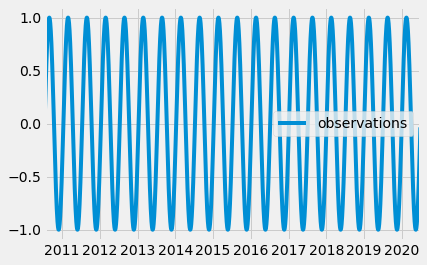

In [5]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=10*364, freq='d')

# take a sine function as the observations
num_periods = 20  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe
df = pd.DataFrame(data=observations, columns=['observations'])
df.index = idx

df.plot()

<a id='Part2.2_link'></a>
### 2.2 separate training and validation data 

In [6]:
# split data at fixed time point into training data (before time point) and validation data (after time point)
data_len = len(df)
TRAIN_SPLIT = int(data_len * 0.7)


In [7]:
# initialize object
obj = Kind_of_Blue.Kind_of_Blue()
print('train split ratio = ', obj.TRAIN_SPLIT_RATIO)

obj._selected_features = ['observations']
obj.df = df
obj.df.head()

train split ratio =  0.7


,observations
2010-07-15,0.000000
2010-07-16,0.034516
2010-07-17,0.068991
2010-07-18,0.103384
2010-07-19,0.137654


In [8]:
# initialize dataset from dataframe 
obj.initialize_dataset()
obj._dataset

array([[ 0.        ],
       [ 0.03451614],
       [ 0.06899114],
       ...,
       [-0.10338393],
       [-0.06899114],
       [-0.03451614]])

<a id='Part3_link'></a>
# 3. feature scaling

<a id='Part3.1_link'></a>
### 3.1 standardize training data

some text here

In [9]:

# # standardize training data
# features = ['observations']
# dataset = df[features].values


# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)


In [10]:
# standardize training data
features = ['observations']
dataset = df[features].values

# take training data only
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)  
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# standardize data
dataset = (dataset-data_mean)/data_std  # note: dataset now np.array, no longer pd.DataFrame

In [11]:
# standardize data
obj.standardize_data()

In [12]:
np.mean(obj._dataset), np.std(obj._dataset)

(7.808161931429672e-18, 0.9999999999999999)

<a id='Part4_link'></a>
# 4. slice data

<a id='Part4.1_link'></a>
### 4.1 update

some text here

In [13]:
# set future time steps to be used in validation set
future_target = int(365/52)

# set number of historical time steps to be used in training set
past_history = int(2*365)

# get sliced training and validation set
x_train, y_train = slice_time_series_data(dataset=dataset, target=dataset[:]
                                          , start_index=0, end_index=TRAIN_SPLIT
                                          , history_size=past_history, target_size=future_target)

x_val, y_val = slice_time_series_data(dataset=dataset, target=dataset[:]
                                      , start_index=TRAIN_SPLIT, end_index=None
                                      , history_size=past_history, target_size=future_target)

print('training set shape: x:{}, y:{}'.format(str(x_train.shape), str(y_train.shape)))
print('validation set shape: x:{}, y:{}'.format(str(x_val.shape), str(y_val.shape)))

training set shape: x:(1818, 730, 1), y:(1818, 7, 1)
validation set shape: x:(355, 730, 1), y:(355, 7, 1)


In [14]:
# bugger and batch size
BUFFER_SIZE = 100000
# BATCH_SIZE = future_target
BATCH_SIZE = 32

# set seed for results to be re-produceable
tf.random.set_seed(22)

# format data such that its acceptable input to the tensor flow model 
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [15]:
future_target_size = int(365/52)
past_history_size = int(2*365)
batch_size = 32
obj.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size
                                , batch_size=batch_size)

training set shape: x:(1818, 730, 1), y:(1818, 7, 1)
validation set shape: x:(355, 730, 1), y:(355, 7, 1)


In [16]:
obj._val_data

<RepeatDataset shapes: ((None, 730, 1), (None, 7, 1)), types: (tf.float64, tf.float64)>

In [17]:
obj._train_data

<RepeatDataset shapes: ((None, 730, 1), (None, 7, 1)), types: (tf.float64, tf.float64)>

In [18]:
# # training data examples
# for x, y in train_data.take(10):
#     multi_step_plot(x[0], y[0], np.array([0]))

<a id='Part5_link'></a>
# 5. setup and compile model

<a id='Part5.1_link'></a>
### 5.1 LSTM model

some text here

In [19]:
# setup sequential model
LSTM_model = tf.keras.models.Sequential()

# choose three layer model
units_1 = 32
units_2 = 32
units_output_layer = 7
# units_3 = 16
LSTM_model.add(tf.keras.layers.LSTM(units_1, return_sequences=True, input_shape=x_train.shape[-2:]))
LSTM_model.add(tf.keras.layers.LSTM(units_2, activation='relu'))
# LSTM_model.add(tf.keras.layers.Dense(units_3)) 
LSTM_model.add(tf.keras.layers.Dense(units_output_layer))  # output layer
# LSTM_model.add(tf.keras.layers.Dense(1))  # output layer

In [20]:
# model = Sequential()
# model.add(Embedding(max_features, 128))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid')) 

In [21]:
# compile model
LSTM_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [22]:
units_1 = 4
units_2 = 8
obj.compile_LSTM_model(units_1=units_1, units_2=units_2)

In [23]:
obj._model

<a id='Part6_link'></a>
# 6. fit model

<a id='Part6.1_link'></a>
### 6.1 LSTM model

some text here

In [24]:
"""
try using something more 'default':
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

"""

"\ntry using something more 'default':\nmodel.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)\n\n"

In [ ]:
EPOCHS = 5
# steps_per_epoch : number of training batches = uniqueTrainingData / batchSize
# https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
num_samples = len(x_train)
STEPS_PER_EPOCH = int(num_samples/batch_size)
VALIDATION_STEPS = 1
LSTM_history = LSTM_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH
                              , validation_data=val_data, validation_steps=VALIDATION_STEPS)

# 

# batch_size = 256
# LSTM_history = LSTM_model.fit(train_data, epochs=EPOCHS, batch_size=batch_size, steps_per_epoch=STEPS_PER_EPOCH)



Epoch 1/20
56/56 [==============================] - 27s 482ms/step - loss: 0.5179 - mse: 0.5179 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 2/20
56/56 [==============================] - 26s 456ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/20
56/56 [==============================] - 26s 460ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/20
56/56 [==============================] - 26s 461ms/step - loss: 4.7665e-04 - mse: 4.7665e-04 - val_loss: 8.3886e-04 - val_mse: 8.3886e-04
Epoch 5/20
56/56 [==============================] - 29s 511ms/step - loss: 3.8194e-04 - mse: 3.8194e-04 - val_loss: 4.6244e-04 - val_mse: 4.6244e-04
Epoch 6/20
56/56 [==============================] - 30s 538ms/step - loss: 2.0006e-04 - mse: 2.0006e-04 - val_loss: 3.0581e-04 - val_mse: 3.0581e-04
Epoch 7/20
56/56 [==============================] - 37s 659ms/step - loss: 1.2427e-04 - mse: 1.2427e-04 - val_loss: 1.9308e-04 - val_mse: 1.9308e-04
Epoch

In [ ]:
epochs = 20

num_samples = len(x_train)
steps_per_epoch = int(num_samples/batch_size)

validation_steps = int(steps_per_epoch/2)

obj.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
              , validation_data=val_data, validation_steps=validation_steps)



Epoch 1/100
47/56 [========================>.....] - ETA: 3s - loss: 0.1041 - mse: 0.1041

<a id='Part7_link'></a>
# 7. loss and error metrics

<a id='Part7.1_link'></a>
### 7.1 LSTM model

some text here

In [17]:
# """
# do you not have to scale things back?
# """

# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

In [24]:
val_data

<RepeatDataset shapes: ((None, 730, 1), (None, 7, 1)), types: (tf.float64, tf.float64)>

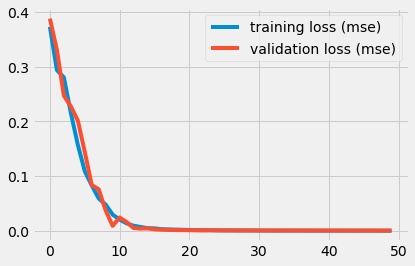

In [73]:
# plot_train_history(LSTM_history, 'Multi-Step Training and validation loss')
plt.plot(LSTM_history.history['mse'], label='training loss (mse)')
plt.plot(LSTM_history.history['val_mse'], label='validation loss (mse)')
plt.legend()
plt.show()

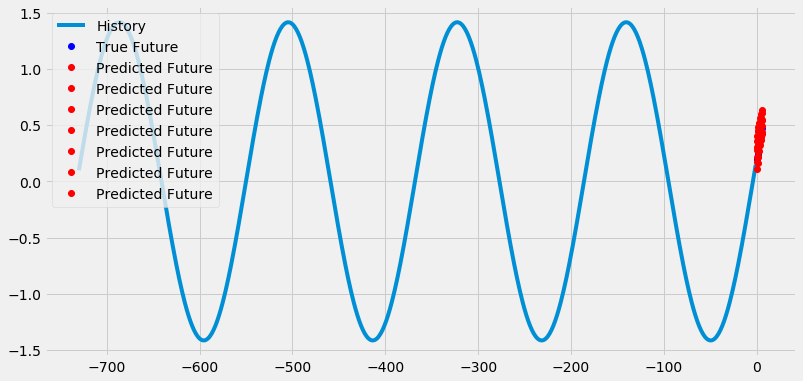

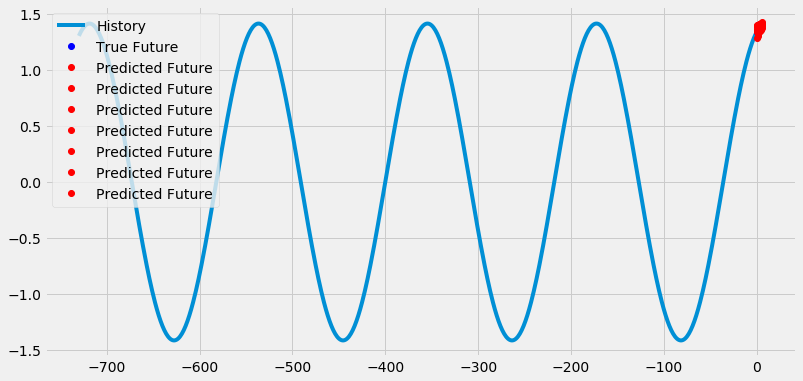

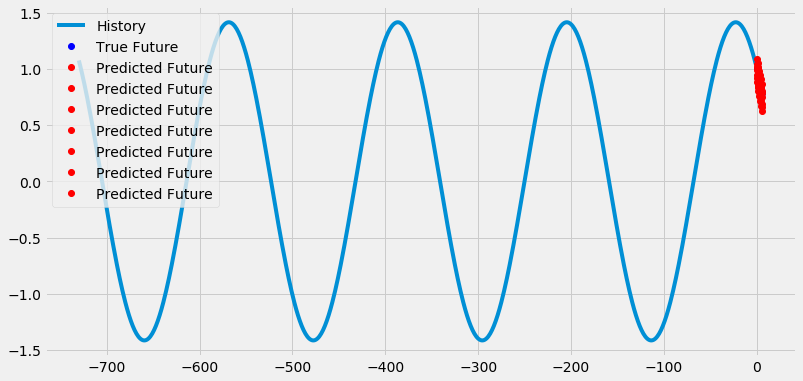

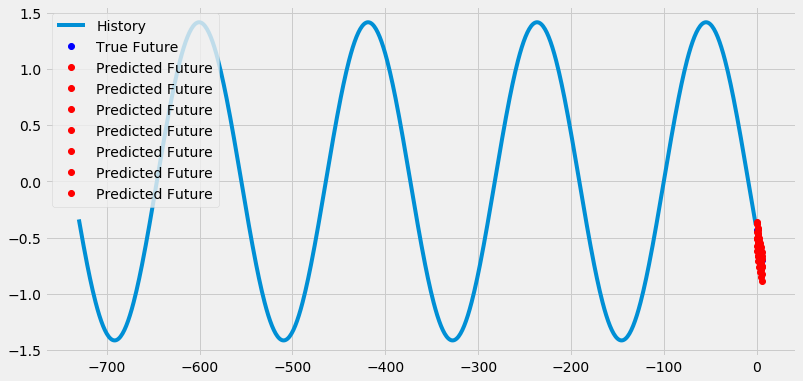

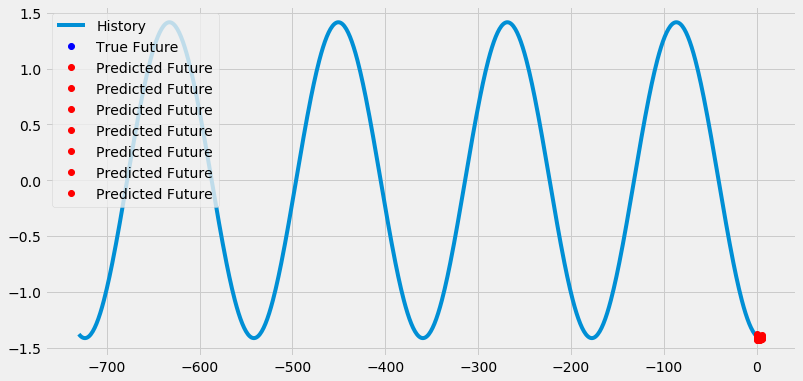

In [76]:
num = 2
for x, y in val_data.take(5):
    multi_step_plot(x[num], y[num], LSTM_model.predict(x)[:future_target])

## auxilary functions

In [3]:
# the following functions are implemented in the class 'Kind_of_Blue' contained in Kind_of_Blue.py

def slice_time_series_data(dataset, target, start_index, end_index, history_size
                           , target_size, step=1, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length, 0))


def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()